#  Spectroscopic measurements data - Soil organic matter content (SOM) prediction
**Objectives:**

1.   Familiarize with the dataset (inspect and clean data).
2.   Compare the estimates **SOM** with the corresponding data
 from POLARIS soil database (Identify, Download, and ExtractPOLARIS data).
3.   Build two models and Evaluate their performance (using the sensor readings and
lab values) to predict **SOM** of closeby fields. 
**Data:**
1. [STENON challege data](https://drive.google.com/file/d/1wHEEg3O9Cjj3cj77j55egPDbJuiOHDBj/view?usp=sharing)
2. [The POLARIS soil database](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/)

**Reference (ANN model result):**

1. https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018WR022797&file=wrcr23830-sup-0001-Text_SI-S01.pdf

In [ ]:
# Install the Python package to view the map on google maps
!pip install geemap --quiet

# Install the Python package to created to manipulate data geo-vector data
!pip install geopandas --quiet

# Install the Python package to plot charts
!pip install matplotlib==3.1.1 --quiet

# Install the Python package to download data from website
!pip install wget --quiet

# Install the Python package to handle geo-vector and raster data
!pip install rasterstats --quiet

In [3]:
# Standard library imports
import argparse
import logging
import sys
import os
# import multiprocessing

In [115]:
# Third party imports
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import folium
import json
import geojson
from shapely.geometry import shape, GeometryCollection
from geojson import Feature, FeatureCollection, Point
import ee
import geemap
import geopandas as gpd
from google.colab import files
from matplotlib.colors import Normalize
import scipy as sp
from scipy.interpolate import interpn
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import math
import wget
from rasterstats import point_query

# Third party imports to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

import seaborn as sns
sns.set(style = 'whitegrid')

# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.disable_dataframe_formatter()
data_table.DataTable.max_columns = 30

# Enable vertical scrolling in code block/output block
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Soil Organic Matter (SOM) prediction using linear regression

## 1.1 Objectives
* Use attributes ( spectroscopic measurements) with numeric values and linear regression for prediction

## 1.2. Data overview

### Data

In [7]:
uploaded = files.upload()

Saving data.csv to data.csv


In [8]:
def csv_valid(infile, arbitrary_number=2048):
  #arbitrary_number is an entirely arbitrary number. It just needs to be big enough to read in at least two or three CSV rows. 
  with open(infile, 'rb') as csvfile:
    try:
      sniffer = csv.Sniffer()
      dialect = sniffer.sniff(csvfile.read(arbitrary_number))
      # Perform various checks on the dialect (e.g., lineseparator, delimiter) to make sure it's sane
      delimiter = dialect.delimiter
      lineseparator = dialect.lineterminator
      # Reset the read position back to the start of the file before reading any entries.
      csvfile.seek(0)

      # Perform header check to make sure it's sane
      has_header = sniffer.has_header(csvfile.read(arbitrary_number))
      logger.info("CSV file is OK!")

      return delimiter, lineseparator, has_header
    except csv.Error:
      # File appears not to be in CSV format; move along
      logger.error ("Invalid CSV file")
      return None

In [9]:
st_path = "./data.csv"

# delimiter, _, _ = csv_valid(st_path)

if os.path.exists(st_path):
  df_data = pd.read_csv(st_path, sep=';')
  print(df_data.info)
else:
  print ("{} does not exists. The following code blocks won't be execused. Please check!".format(st_path))

<bound method DataFrame.info of       measurement_ID                   lat_lng location        som  nir_1370  \
0                  0  (41.2799111,-92.0301512)  field_A   2.038524  0.268311   
1                  1  (41.2798524,-92.0294544)  field_A  17.443334  0.411358   
2                  2  (41.2798545,-92.0294499)  field_A   2.227260  0.402013   
3                  3   (41.2796759,-92.027938)  field_A   2.369437  0.506582   
4                  4   (41.2796802,-92.027932)  field_A   2.345968  0.475707   
...              ...                       ...      ...        ...       ...   
1068            1068  (41.2718012,-92.0390603)  field_B   1.919485  0.421228   
1069            1069  (41.2717968,-92.0390726)  field_B   1.702884  0.451167   
1070            1070  (41.2717812,-92.0374845)  field_B   1.555839  0.489369   
1071            1071  (41.2717374,-92.0375016)  field_B   1.644490  0.507497   
1072            1072  (41.2717458,-92.0374918)  field_B   1.591437  0.447848   

      n

In [10]:
print(df_data.head(2))

   measurement_ID                   lat_lng location        som  nir_1370  \
0               0  (41.2799111,-92.0301512)  field_A   2.038524  0.268311   
1               1  (41.2798524,-92.0294544)  field_A  17.443334  0.411358   

   nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  ...  nir_2486  nir_2490  \
0  0.266145  0.262247  0.256983  0.250741  0.243620  ...  0.122705  0.121610   
1  0.407535  0.401783  0.393936  0.384204  0.372926  ...  0.165669  0.164012   

   nir_2494  nir_2498  nir_2502  nir_2506  nir_2510  nir_2514  nir_2518  \
0  0.120648  0.119822  0.119134  0.118585  0.118178  0.117913  0.117794   
1  0.162577  0.161365  0.160374  0.159602  0.159048  0.158710  0.158586   

   nir_2522  
0  0.117820  
1  0.158674  

[2 rows x 293 columns]


In [11]:
print(df_data.tail(2))

      measurement_ID                   lat_lng location       som  nir_1370  \
1071            1071  (41.2717374,-92.0375016)  field_B  1.644490  0.507497   
1072            1072  (41.2717458,-92.0374918)  field_B  1.591437  0.447848   

      nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  ...  nir_2486  \
1071  0.503908  0.497956  0.488233  0.475167  0.459762  ...  0.172855   
1072  0.444600  0.439651  0.431790  0.421130  0.408224  ...  0.165309   

      nir_2490  nir_2494  nir_2498  nir_2502  nir_2506  nir_2510  nir_2514  \
1071  0.170890  0.169130  0.167590  0.166287  0.165238  0.164459  0.163967   
1072  0.163435  0.161741  0.160241  0.158948  0.157876  0.157039  0.156451   

      nir_2518  nir_2522  
1071  0.163779  0.163907  
1072  0.156125  0.156074  

[2 rows x 293 columns]


In [12]:
df_data.describe()

measurement_ID          som     nir_1370     nir_1374     nir_1378  \
count     1073.000000  1071.000000  1073.000000  1073.000000  1073.000000   
mean       536.000000     2.229820     0.447966     0.444705     0.439789   
std        309.892723     0.720085     0.081036     0.080482     0.079648   
min          0.000000     1.146822     0.114487     0.114780     0.114832   
25%        268.000000     1.864802     0.417341     0.414102     0.409172   
50%        536.000000     2.127110     0.461385     0.457803     0.452487   
75%        804.000000     2.411847     0.496091     0.492194     0.486352   
max       1072.000000    17.443334     0.722441     0.718165     0.711620   

          nir_1382     nir_1386     nir_1390     nir_1394     nir_1398  ...  \
count  1072.000000  1073.000000  1072.000000  1073.000000  1073.000000  ...   
mean      0.432199     0.421409     0.408327     0.393682     0.377905  ...   
std       0.078354     0.076481     0.074241     0.071708     0.069052  ...   
min       0.113912     0.111786     0.108984     0.106092     0.103083  ...   
25%       0.402044     0.391879     0.378550     0.365659     0.350714  ...   
50%       0.444243     0.432546     0.418822     0.402933     0.385649  ...   
75%       0.477705     0.465522     0.451310     0.435061     0.418003  ...   
max       0.700936     0.686183     0.668080     0.647280     0.631115  ...   

          nir_2486     nir_2490     nir_2494     nir_2498     nir_2502  \
count  1073.000000  1073.000000  1072.000000  1073.000000  1073.000000   
mean      0.174012     0.172116     0.170443     0.168944     0.167696   
std       0.034241     0.033881     0.033547     0.033221     0.032933   
min       0.040231     0.039920     0.039655     0.039435     0.039256   
25%       0.151034     0.149306     0.147870     0.146755     0.145808   
50%       0.172747     0.170898     0.169273     0.167730     0.166661   
75%       0.193789     0.191732     0.190121     0.188448     0.186827   
max       0.376515     0.373556     0.370982     0.368816     0.367055   

          nir_2506     nir_2510     nir_2514     nir_2518     nir_2522  
count  1073.000000  1073.000000  1073.000000  1073.000000  1073.000000  
mean      0.166688     0.165929     0.165429     0.165200     0.165248  
std       0.032679     0.032466     0.032299     0.032183     0.032121  
min       0.039113     0.039001     0.038915     0.038851     0.038803  
25%       0.144741     0.144004     0.143575     0.143463     0.143510  
50%       0.165694     0.164924     0.164483     0.164273     0.164455  
75%       0.185822     0.184974     0.184316     0.183966     0.183918  
max       0.365696     0.364736     0.364173     0.364004     0.364226  

[8 rows x 291 columns]

In [13]:
data_table.DataTable(df_data, include_index=False, num_rows_per_page=10)

In [14]:
# data_table.DataTable(df_data.filter(regex='nir_').describe(), include_index=False, num_rows_per_page=10)

### Inspect the input data and do primary data cleanning (Identify and drop missing/incomplete record(s)) 

In [15]:
# Count number of Rows having NaN or Empty element(s)
nrows_having_NaN = df_data.shape[0] - df_data.dropna().shape[0]
print ("Total number of Rows contain NaN or Empty element(s): {}".format(nrows_having_NaN))

Total number of Rows contain NaN or Empty element(s): 21


In [16]:
nrows_index_having_NaN = df_data.index[df_data.isnull().any(axis=1)]
print ("Following Rows: {} having NaN or Empty element(s)".format(nrows_index_having_NaN.tolist()))

Following Rows: [6, 7, 12, 148, 380, 410, 459, 548, 549, 605, 817, 827, 942, 943, 956, 1039, 1042, 1056, 1059, 1063, 1068] having NaN or Empty element(s)


In [17]:
# Count number of Rows having  all element are NaN or Empty
nrows_all_NaN = df_data.shape[0] - df_data.isnull().all(axis=1).shape[0] 
print ("Total number of Rows having  all elements are NaN or Empty: {}".format(nrows_all_NaN))

if nrows_all_NaN> 0:
    print (df_data.loc[nrows_all_NaN])
    df_data = df_data.loc[df_data.index.drop(nrows_all_NaN)]

Total number of Rows having  all elements are NaN or Empty: 0


In [18]:
# Drop Rows with missing values or NaN
df_data = df_data.dropna()

# Extract wave length
wave_length = [int(item.split('_')[1]) for item in df_data.columns.tolist() if 'nir_' in item]
print (wave_length)

# Columns of Interest
ioc_name = [col for col in df_data.columns if (("nir_" in col) and (df_data[col].dtype == "float64"))]
print (ioc_name)

[1370, 1374, 1378, 1382, 1386, 1390, 1394, 1398, 1402, 1406, 1410, 1414, 1418, 1422, 1426, 1430, 1434, 1438, 1442, 1446, 1450, 1454, 1458, 1462, 1466, 1470, 1474, 1478, 1482, 1486, 1490, 1494, 1498, 1502, 1506, 1510, 1514, 1518, 1522, 1526, 1530, 1534, 1538, 1542, 1546, 1550, 1554, 1558, 1562, 1566, 1570, 1574, 1578, 1582, 1586, 1590, 1594, 1598, 1602, 1606, 1610, 1614, 1618, 1622, 1626, 1630, 1634, 1638, 1642, 1646, 1650, 1654, 1658, 1662, 1666, 1670, 1674, 1678, 1682, 1686, 1690, 1694, 1698, 1702, 1706, 1710, 1714, 1718, 1722, 1726, 1730, 1734, 1738, 1742, 1746, 1750, 1754, 1758, 1762, 1766, 1770, 1774, 1778, 1782, 1786, 1790, 1794, 1798, 1802, 1806, 1810, 1814, 1818, 1822, 1826, 1830, 1834, 1838, 1842, 1846, 1850, 1854, 1858, 1862, 1866, 1870, 1874, 1878, 1882, 1886, 1890, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1934, 1938, 1942, 1946, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022, 2026, 2030, 203

No handles with labels found to put in legend.
No handles with labels found to put in legend.


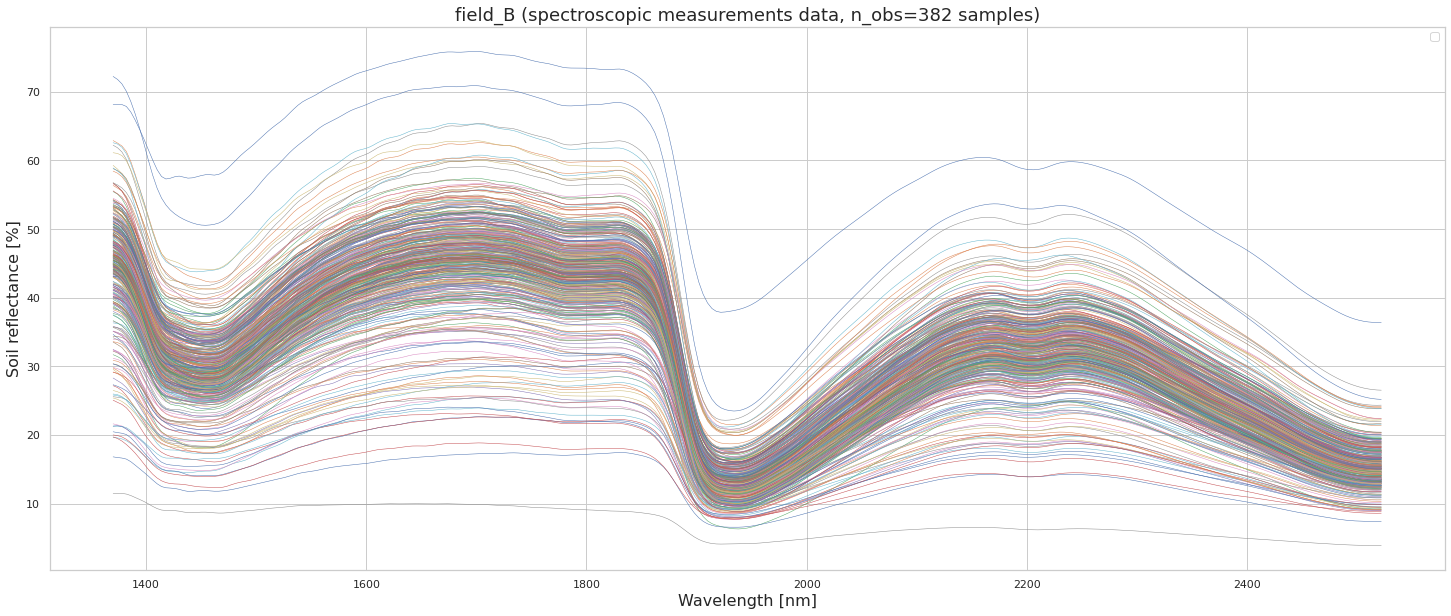

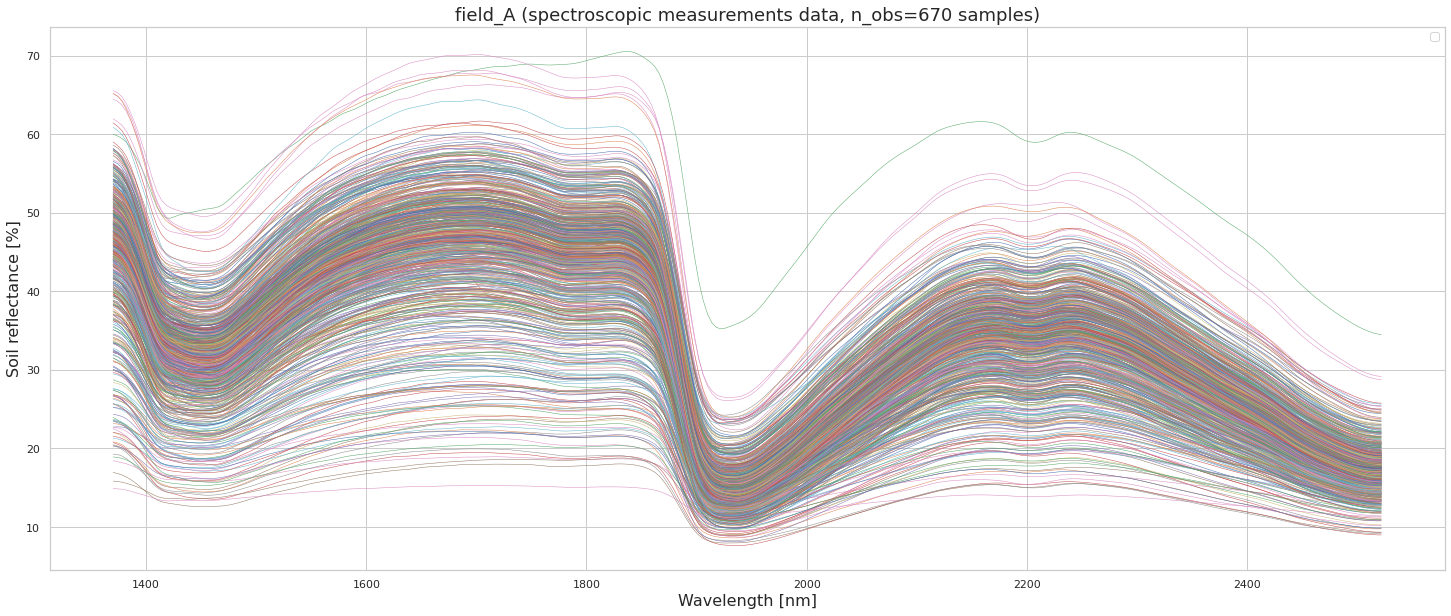

In [149]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  df_field_nir = df_field.filter(regex='nir_')
  plt.figure(figsize=(25, 10))
  plt.clf

  for _, row in df_field_nir.iterrows():
      plt.plot(wave_length, 100*row, linewidth=0.5)

  plt.xlabel("Wavelength [nm]", fontsize=16)
  plt.ylabel("Soil reflectance [%]", fontsize=16)
  plt.title ("{} (spectroscopic measurements data, n_obs={} samples)".format(location_name, df_field.shape[0]), fontsize=18)
  plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


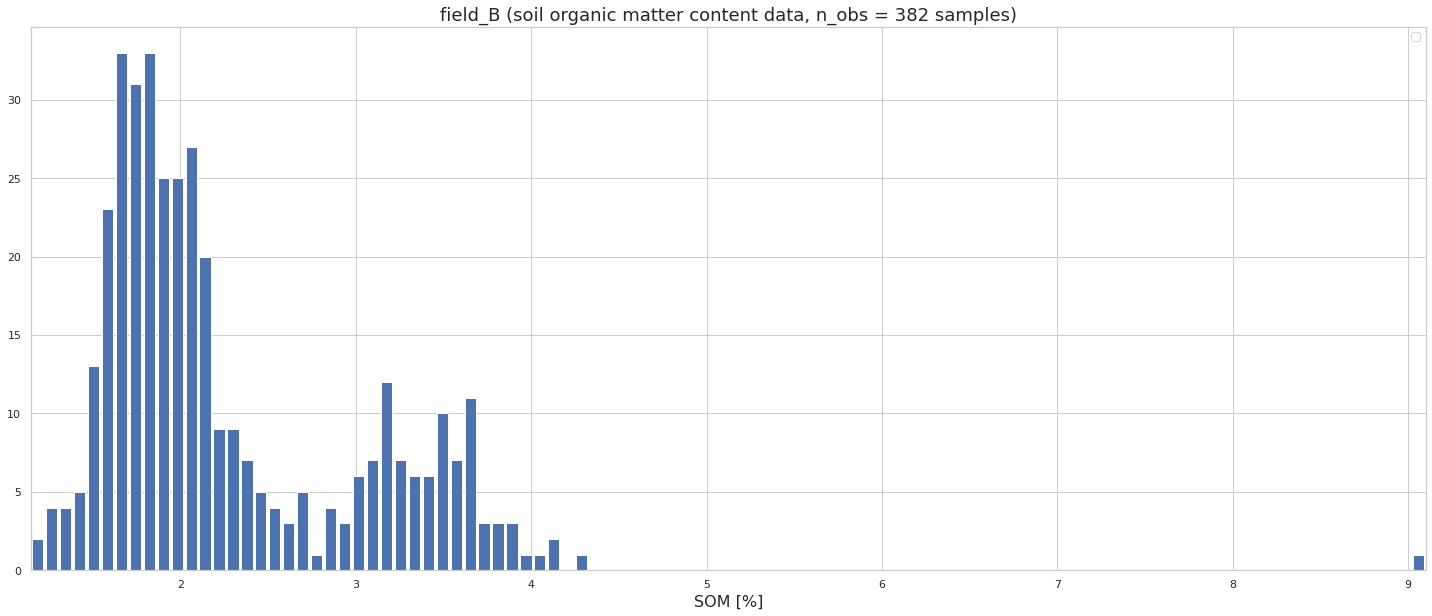

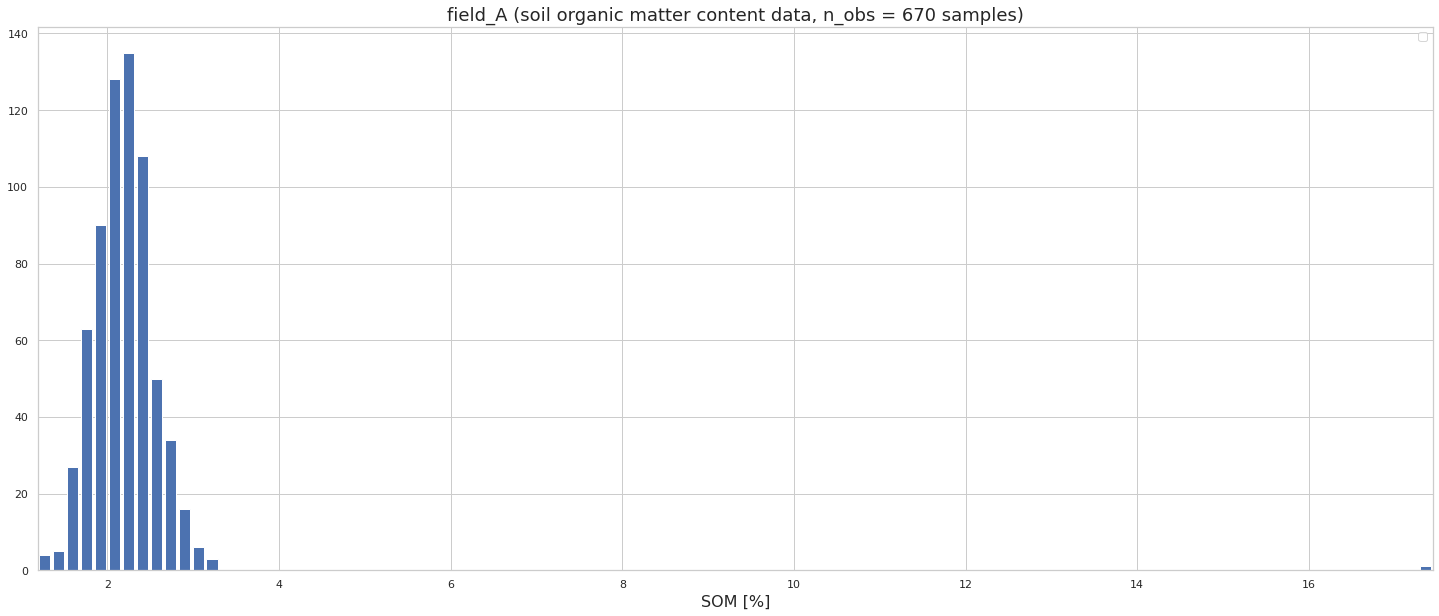

In [150]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  plt.figure(figsize=(25, 10))
  plt.clf

  plt.hist(df_field['som'], bins=100, histtype='bar', rwidth=0.8)
  plt.xlim(df_field['som'].min(), df_field['som'].max())
  plt.xlabel("SOM [%]", fontsize=16)
  plt.title ("{} (soil organic matter content data, n_obs = {} samples)".format(location_name, df_field['som'].shape[0]), fontsize=18)
  plt.legend()

In [21]:
# g = sns.FacetGrid(df_data, col="location", margin_titles=True, height=4)
# g.map(plt.scatter, "nir_2522", "som", color="#338844", edgecolor="white", s=50, lw=1)

In [22]:
# sns.lmplot('nir_1370', 'nir_2522', data=df_data, fit_reg=True)

In [23]:
def density_scatter(df, field_name, xcol='nir_2522', ycol='som', ax = None, sort=True, bins=20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """

    x = df_field[xcol].to_numpy()
    y = df_field[ycol].to_numpy()

    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    plt.xlabel(xcol, fontsize=16)
    plt.ylabel(ycol, fontsize=16)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize=18)
    ax.set_title ("{} (Original clean data)".format(field_name), fontsize=18)
    plt.show()

    return ax

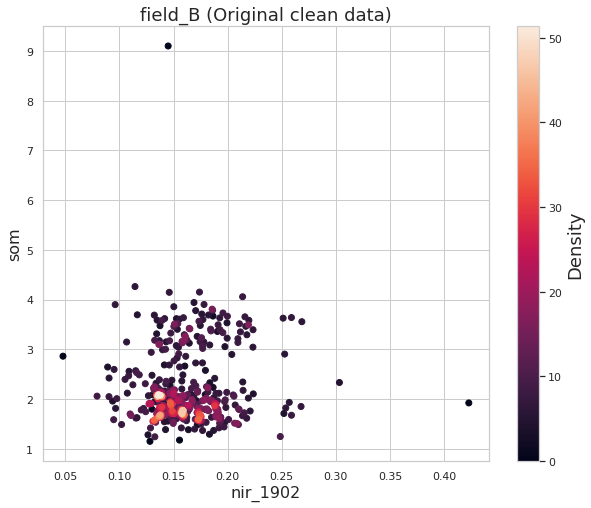

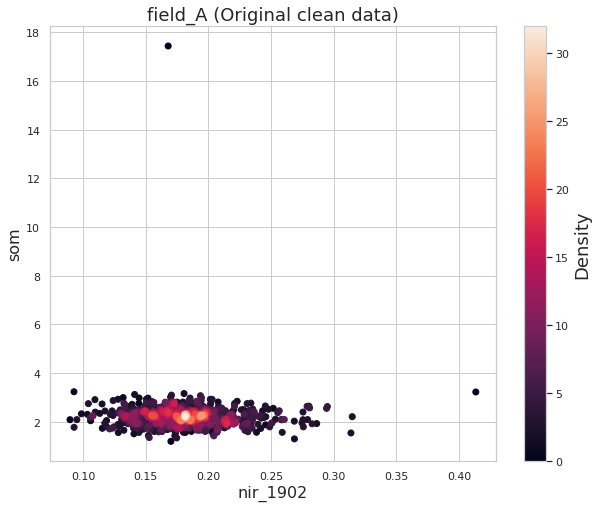

In [156]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  density_scatter(df_field, location_name, xcol='nir_1902', ycol='som', bins=[100,100])

In [25]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

In [26]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [27]:
# Conver pandas dataframe into geojson format
def pandas_to_geojson(df, out_geojson=None, latitude_longitude="lat_lng", encoding="utf-8",):
  """Creates points for a Pandas DataFrame and exports data as a GeoJSON.

  Args:
      df (pandas.DataFrame): The input Pandas DataFrame.
      out_geojson (str): The file path to the exported GeoJSON. Default to None.
      latitude (str, optional): The name of the column containing latitude coordinates. Defaults to "latitude".
      longitude (str, optional): The name of the column containing longitude coordinates. Defaults to "longitude".
      encoding (str, optional): The encoding of characters. Defaults to "utf-8".

  """

  if out_geojson is not None:
    out_dir = os.path.dirname(os.path.abspath(out_geojson))
    if not os.path.exists(out_dir):
      os.makedirs(out_dir)

  features = df.apply(
    lambda row: Feature(
        geometry=Point((float(row['lat_lng'][1:-1].split(',')[1]), float(row['lat_lng'][1:-1].split(',')[0]))),
        properties=dict(row),
    ),
    axis=1,
  ).tolist()

  geojson_obj = FeatureCollection(features=features)
  coords = np.array(list(geojson.utils.coords(geojson_obj)))

  #delete [0, 0] from coords
  coords = np.delete(coords, [0, 0], axis=0)
  area_extent = coords[:,0].min(), coords[:,0].max(), coords[:,1].min(), coords[:,1].max()

  if out_geojson is None:
    return [False, geojson_obj, area_extent]
  else:
    with open(out_geojson, "w", encoding=encoding) as f:
      f.write(json.dumps(geojson_obj))
    return [True, geojson_obj, area_extent]

In [28]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(0, 0), zoom=3, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

### Handling missing and outlier data

* Identify and drop wrong (geo-location) record(s) from data.
* Identify missing and outlier data and update it with mean for the columns containing numeric values.  

In [29]:
df_data_correct_geo = df_data[df_data['lat_lng'] != '(0,0)']

_, geojson_obj, area_extent  = pandas_to_geojson(df_data_correct_geo.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(0, 0), zoom=3, lite_mode=True, add_google_map=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [30]:
df_data_correct_geo = df_data[df_data['lat_lng'] != '(0,0)']

df_data_correct_geo.columns

Index(['measurement_ID', 'lat_lng', 'location', 'som', 'nir_1370', 'nir_1374',
       'nir_1378', 'nir_1382', 'nir_1386', 'nir_1390',
       ...
       'nir_2486', 'nir_2490', 'nir_2494', 'nir_2498', 'nir_2502', 'nir_2506',
       'nir_2510', 'nir_2514', 'nir_2518', 'nir_2522'],
      dtype='object', length=293)

In [31]:
_temp_geo = df_data_correct_geo["lat_lng"].str.slice(start=1,stop=-1).str.split(",", n = 1, expand = True)
df_data_correct_geo["lat"] = _temp_geo[0]
df_data_correct_geo['lng'] = _temp_geo[1]
df_data_correct_geo[["lat", "lng"]] = df_data_correct_geo[["lat", "lng"]].apply(pd.to_numeric)
lat_mean = df_data_correct_geo["lat"].mean()
lon_mean = df_data_correct_geo["lng"].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [32]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data_correct_geo.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [33]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data_correct_geo.iloc[:, :4][df_data_correct_geo['location']== 'field_A'])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [34]:
_, geojson_obj, area_extent = pandas_to_geojson(df_data_correct_geo.iloc[:, :4][df_data_correct_geo['location']== 'field_B'])
fc = geemap.geojson_to_ee(geojson_obj)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [35]:
# states = ee.FeatureCollection("TIGER/2018/States")
# style = {'color': 'black', 'fillColor': "00000000"}
# Map.addLayer(states.style(**style), {}, "US States")

Map.remove_labels()

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=16, lite_mode=True, add_google_map=True)

# Labeling a Pandas DataFrame
Map.add_labels(
    df_data_correct_geo[['location', 'lat', 'lng', 'som']],
    "location",
    x='lng',
    y='lat',
    font_size="16pt",
    font_color="red",
    font_family="arial",
    # font_weight="bold",
)
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [36]:
_,geojson_obj, extent = pandas_to_geojson(df_data_correct_geo, './data.geojson')
if geojson_obj is True:
  print ('You can start download geojson file []./data.geojson] for further local data inspection and correction')
else:
  print ('You would like to go further with data inspection in Colab!')

You would like to go further with data inspection in Colab!


### Compare with POLARIS soil database

1.   Identity POLARIS tile(s) data
2.   Download selected POLARIS tile(s) data
3.   Perform comparison

In [37]:
# Default POLARIS setting values
DEFAULT_POLARIS_URL = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'

DEFAULT_POLARIS_LAYERS = ['0_5', '5_15', '15_30', '30_60', '60_100', '100_200']
DEFAULT_POLARIS_STATISTICS = ['mean', 'mode', 'p5', 'p50', 'p95']
DEFAULT_POLARIS_PARAMETERS = ['alpha', 'bd', 'clay', 'hb', 'ksat', 'lambda', 'n', 'om', 'ph', 'sand', 'silt', 'theta_r', 'theta_s']

DEFAULT_POLARIS_WORKING_DIRECTORY = './polaris'

layers = DEFAULT_POLARIS_LAYERS
statistics = DEFAULT_POLARIS_STATISTICS
parameters = DEFAULT_POLARIS_PARAMETERS
template_url = DEFAULT_POLARIS_URL

output_base_path = DEFAULT_POLARIS_WORKING_DIRECTORY
os.makedirs(output_base_path, exist_ok=True)

def download_polaris_data(area_extent, output_base_path=output_base_path, layers=layers, statistics=statistics, parameters=parameters):

    # import pdb;pdb.set_trace()
    (minLon, maxLon, minLat, maxLat) = area_extent
    domain_extent = {'lon': [math.floor(minLon), int(math.ceil(maxLon))], 'lat':[math.floor(minLat), int(math.ceil(maxLat))]}

    def generate_url_path(output_base_path, domain_extent):
        ''' TODO': Write discription'''

        url_path_lst = []
        lat_range = range(domain_extent['lat'][0],domain_extent['lat'][1])
        lon_range = range(domain_extent['lon'][0],domain_extent['lon'][1])
        for layer in layers:
            for stat in statistics:
                for param in parameters:
                    for lat in lat_range:
                        for lon in lon_range:
                            url = template_url.format(param,stat,layer,str(lat),str(lat+1),str(lon),str(lon+1))
                            temp_path = os.path.join(output_base_path, '{}/{}/{}/'.format(param,stat,layer))
                            if not os.path.exists(temp_path):
                                os.makedirs(temp_path)
                            url_path_lst += [[url, temp_path]]

        return url_path_lst


    # def run_process(url, output_path):
    #     wget.download(url, out=output_path)


    # Generate URL path for the data that we intersted in
    url_path_lst = generate_url_path(output_base_path, domain_extent)

    # cpus = multiprocessing.cpu_count()
    # max_pool_size = 6
    # pool = multiprocessing.Pool(cpus if cpus < max_pool_size else max_pool_size)

    for url, path in url_path_lst:
        print('Beginning file download with wget module {n}'.format(n=url))
        wget.download(url, out=path)
        # pool.apply_async(run_process, args=(url, path, ))

    # pool.close()
    # pool.join()

    for url, path in url_path_lst:
      if os.path.exists(path):
        print("File(s) in {} downloaded successfully from {}".format(path, url))
      else:
        print("Failed when download file {} from {}".format(path, url))

    return url_path_lst

In [38]:
# Default CHALLENGE setting values
DEFAULT_CHALLENGE_LAYERS = ['0_5', '5_15', '15_30']
DEFAULT_CHALLENGE_STATISTICS = ['mean', 'mode', 'p5', 'p50', 'p95']
DEFAULT_CHALLENGE_PARAMETERS = ['om']

_, geojson_obj, area_extent = pandas_to_geojson(df_data_correct_geo, './data.geojson')
url_path_lst = download_polaris_data(area_extent, layers=DEFAULT_CHALLENGE_LAYERS, statistics=DEFAULT_CHALLENGE_STATISTICS, parameters=DEFAULT_CHALLENGE_PARAMETERS)

Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mean/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mode/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p5/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p50/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p95/0_5/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mean/5_15/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/mode/5_15/lat4142_lon-93-92.tif
Beginning file download with wget module http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/om/p

In [39]:
def ZonalStats(in_vec, in_rst_list, out_vec=None, interest_cols=[], attribute_name='som_polaris'):
    """TODO"""
    # in_vec - shapefile path
    # in_rst_list - raster path
    # the result is df as DataFrame

    shape_gdf = gpd.read_file(in_vec)
    for in_rst in in_rst_list:
        file_pattern = '_'.join(in_rst.split('/')[-3:-1])
        column_name = "{}_{}".format(attribute_name, file_pattern)
        zonalSt = point_query(in_vec, in_rst, band=1, nodata=-9999, interpolate='nearest')
        df = pd.DataFrame (zonalSt, index=shape_gdf.index, columns = [column_name])
        shape_gdf = pd.concat([shape_gdf, df], axis=1)
        interest_cols.append(column_name)

    interest_cols.append('geometry')
    # re-order the columns
    gdf = gpd.GeoDataFrame(shape_gdf, geometry=shape_gdf.geometry)
    gdf = gdf[interest_cols]

    if out_vec is not None:
        # Alternatively, you can write GeoJSON to file:
        gdf.to_file(out_vec, driver="GeoJSON")  
    
    df = gdf.drop(['geometry'], axis=1, errors='ignore')

    return df

In [121]:
# Extract data from POLARIS soil database")
geojson_fn = './data.geojson'
in_rst_list =['{}{}'.format(item[1], os.path.basename(item[0])) for item in url_path_lst]
selected_cols=['measurement_ID', 'location', 'som']
out_geojson_with_polaris = './data_with_SOM_from_polaris.geojson'

df_data_with_polaris_data = ZonalStats(geojson_fn, in_rst_list, out_vec=out_geojson_with_polaris, interest_cols=selected_cols)

[Table 1. Soil Properties That Are Mapped Over the Contiguous United States at a 30-m Spatial Resolution
](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR022797)

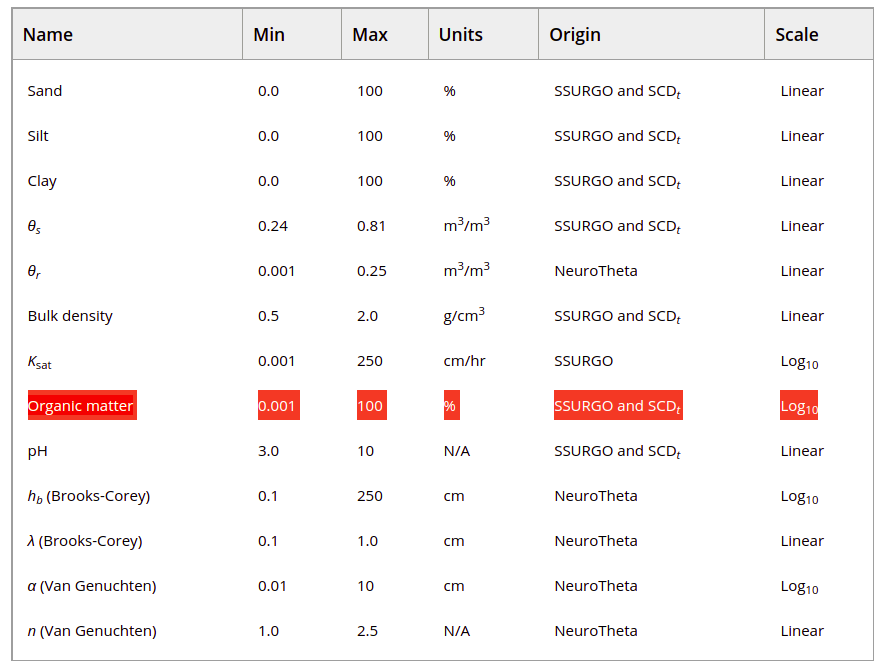


In [122]:
# Let’s define a UDF(User defined function).
# def func_1(a,b):
#     return a + b

# df["C"] = func_1(df["A"].to_numpy(),df["B"].to_numpy())

# import pandas as pd

# df = pd.DataFrame({'ID':['1','2','3'], 'col_1': [0,2,3], 'col_2':[1,4,5]})
# mylist = ['a','b','c','d','e','f']

# def get_sublist(sta,end):
#     return mylist[sta:end+1]

# def get_sublist_list(cols):
#     return [get_sublist(cols[0],cols[1])]

# def unlist(list_of_lists):
#     return list_of_lists[0]

# df['col_3'] = df[['col_1','col_2']].apply(get_sublist_list,axis=1).apply(unlist)



def compute_logData(x):
   return np.log(x)

df_data_with_polaris_data['som_shanon'] = df_data_with_polaris_data[['som']].apply(compute_logData, axis=1)

In [ ]:
df_data_with_polaris_data

In [124]:
ts_hilo_corr_attributes = df_data_with_polaris_data.columns[3:-1].tolist()

df_data_with_polaris_data_field_A = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_A']
df_data_with_polaris_data_field_B = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_B']

In [ ]:
# ts_hilo_corr_attributes

In [ ]:
# df_data_with_polaris_data_field_B['som_polaris_mean_0_5'].plot.hist(bins=100, alpha=0.5)

In [ ]:
# df_data_with_polaris_data_field_B['som_polaris_p95_0_5'].plot.hist(bins=100, alpha=0.5)

In [ ]:
y_name = 'som_shanon'
features_names = ts_hilo_corr_attributes
column_names = features_names + [y_name]

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=df_data_with_polaris_data_field_A, x=x_var, y=y_name, ax=ax)
g.tight_layout()

#move overall title up
g.fig.subplots_adjust(top=0.9)

g.fig.suptitle('SOM (Shanon vs Polaris, field_A)')
plt.savefig('Compare_with_POLARIS_SOM_field_A.png')
plt.show()

In [ ]:
y_name = 'som_shanon'
features_names = ts_hilo_corr_attributes
column_names = features_names + [y_name]

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=df_data_with_polaris_data_field_B, x=x_var, y=y_name, ax=ax)
    # .set(title='SOM (Shanon vs Polaris, field_B)')

g.tight_layout()

#move overall title up
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('SOM (Shanon vs Polaris, field_B)')
plt.savefig('Compare_with_POLARIS_SOM_field_B.png')
plt.show()

In [139]:
new_attributes = []
# _num_stats = len(DEFAULT_CHALLENGE_STATISTICS)
for i, name in enumerate(DEFAULT_CHALLENGE_STATISTICS):
  df_data_with_polaris_data["som_polaris_%s_0_30"%name] = [np.median(row) for row in df_data_with_polaris_data[ts_hilo_corr_attributes[i::5]].itertuples(index=False)]
  new_attributes.append("som_polaris_%s_0_30"%name)

df_data_with_polaris_data_field_A_comb = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_A']
df_data_with_polaris_data_field_B_comb = df_data_with_polaris_data[df_data_with_polaris_data['location']== 'field_B']

print(new_attributes)

['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p5_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']


In [ ]:
y_name = 'som_shanon'
features_names = ['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']
df_plot = df_data_with_polaris_data_field_A_comb

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=2, sharex=False, size = 6)
for ax, x_var in zip(g.axes, features_names):
    # sns.scatterplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax)

    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # Fit the regression model using log(x):
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, x_estimator=np.mean, logx=True)

    # Fit a logistic regression; jitter the y variable and use fewer bootstrap iterations:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, logistic=True, n_boot=500, y_jitter=.03)

    # Fit a robust regression and don’t plot a confidence interval:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, 
    #             scatter_kws={"color": "black"}, line_kws={"color": "red"},
    #             robust=True, ci=None)
    
    data = df_plot[df_plot[y_name]<200]
    sns.regplot(data=data, x=x_var, y=y_name, ax=ax, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"},
                scatter = True, ci = 0, fit_reg = True)

    r, p = sp.stats.pearsonr(data[x_var], data[y_name])
    ax.text(.02, 1.0, 'r={:.2f}, p={:.2g}'.format(r, p), weight='bold', fontsize=15, transform=ax.transAxes)

g.tight_layout()
# g.set(xlim=(0, 1.2))
#move overall title up
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('SOM (Shanon vs Polaris_median, field_A)', fontsize=20)

plt.savefig('Compare_with_POLARIS_SOM_field_A_0_30_median.png')
plt.show()

In [ ]:
y_name = 'som_shanon'
features_names = ['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']
df_plot = df_data_with_polaris_data_field_B_comb

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=2, sharex=False, size = 6)
for ax, x_var in zip(g.axes, features_names):
    # sns.scatterplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax)

    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # Fit the regression model using log(x):
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, x_estimator=np.mean, logx=True)

    # Fit a logistic regression; jitter the y variable and use fewer bootstrap iterations:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, logistic=True, n_boot=500, y_jitter=.03)

    # Fit a robust regression and don’t plot a confidence interval:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, 
    #             scatter_kws={"color": "black"}, line_kws={"color": "red"},
    #             robust=True, ci=None)
    
    data = df_plot[df_plot[y_name]<100]
    sns.regplot(data=data, x=x_var, y=y_name, ax=ax, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"},
                scatter = True, ci = 0, fit_reg = True)

    r, p = sp.stats.pearsonr(data[x_var], data[y_name])
    ax.text(.02, 1.0, 'r={:.2f}, p={:.2g}'.format(r, p), weight='bold', fontsize=15, transform=ax.transAxes)

g.tight_layout()
# g.set(xlim=(0, 1.2))
#move overall title up
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('SOM (Shanon vs Polaris_median, field_B)', fontsize=20)

plt.savefig('Compare_with_POLARIS_SOM_field_B_0_30_median.png')
plt.show()

# **Group data by location**

In [157]:
def group_points_sample(in_vec, out_vec, interest_cols=['lat', 'lng']):
    from sklearn.cluster import DBSCAN

    # https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5
    df = gpd.read_file(in_vec)

    X = df[interest_cols].to_numpy()
    dbscan = DBSCAN(eps = 0.00007, min_samples = 2)
    model = dbscan.fit(X)

    labels = model.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    df_label = pd.DataFrame(model.labels_, index=df.index, columns = ["group"])
    shape_gdf = pd.concat([df, df_label], axis=1)
    gdf = gpd.GeoDataFrame(shape_gdf, geometry=shape_gdf.geometry)

    if out_vec is not None:
        # Alternatively, you can write GeoJSON to file:
        gdf.to_file(out_vec, driver="GeoJSON")  

    df = gdf.drop(['geometry'], axis=1, errors='ignore')
    
    return df

In [ ]:
# Extract data from POLARIS soil database")
geojson_fn = './data.geojson'
in_rst_list =['{}{}'.format(item[1], os.path.basename(item[0])) for item in url_path_lst]
selected_cols=['measurement_ID', 'lat', 'lng', 'location', 'som']
out_geojson_with_polaris = './data_latlng_with_SOM_from_polaris.geojson'

df_latlng_with_polaris_data = ZonalStats(geojson_fn, in_rst_list, out_vec=out_geojson_with_polaris, interest_cols=selected_cols)

In [164]:
out_geojson_with_group_by_location = './data_latlng_with_SOM_from_polaris_group.geojson'
selected_cols = ['lat', 'lng']
df_with_group_by_location = group_points_sample(out_geojson_with_polaris, out_vec=out_geojson_with_group_by_location, interest_cols=selected_cols)
# df_with_group_by_location.to_csv(os.path.join(out_dir, 'clean_data/data_clean_with_group_by_location.csv'))

Estimated number of clusters: 156
Estimated number of noise points: 1


In [ ]:
df_with_group_by_location_field_A = df_with_group_by_location[df_with_group_by_location['location'] == 'field_A'].groupby(['group']).median()
df_with_group_by_location_field_A['som_shanon'] = df_with_group_by_location_field_A[['som']].apply(compute_logData, axis=1)
ts_hilo_corr_attributes = [col for col in df_with_group_by_location_field_A.columns.tolist() if 'som_polaris_' in col]

y_name = 'som_shanon'
features_names = ts_hilo_corr_attributes
column_names = features_names + [y_name]

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=df_with_group_by_location_field_A, x=x_var, y=y_name, ax=ax)
g.tight_layout()

#move overall title up
g.fig.subplots_adjust(top=0.9)

g.fig.suptitle('SOM (Shanon vs Polaris, field_A)')
plt.savefig('Compare_combined_with_POLARIS_SOM_field_A.png')
plt.show()

In [ ]:
df_with_group_by_location_field_B = df_with_group_by_location[df_with_group_by_location['location'] == 'field_B'].groupby(['group']).median()
df_with_group_by_location_field_B['som_shanon'] = df_with_group_by_location_field_B[['som']].apply(compute_logData, axis=1)
ts_hilo_corr_attributes = [col for col in df_with_group_by_location_field_B.columns.tolist() if 'som_polaris_' in col]

y_name = 'som_shanon'
features_names = ts_hilo_corr_attributes
column_names = features_names + [y_name]

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=5, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=df_with_group_by_location_field_B, x=x_var, y=y_name, ax=ax)
g.tight_layout()

#move overall title up
g.fig.subplots_adjust(top=0.9)

g.fig.suptitle('SOM (Shanon vs Polaris, field_B)')
plt.savefig('Compare_combined_with_POLARIS_SOM_field_B.png')
plt.show()

In [182]:
new_attributes = []
# _num_stats = len(DEFAULT_CHALLENGE_STATISTICS)
for i, name in enumerate(DEFAULT_CHALLENGE_STATISTICS):
  df_with_group_by_location["som_polaris_%s_0_30"%name] = [np.median(row) for row in df_with_group_by_location[ts_hilo_corr_attributes[i::5]].itertuples(index=False)]
  new_attributes.append("som_polaris_%s_0_30"%name)

print(new_attributes)

['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p5_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']


In [ ]:
df_with_group_by_location_field_B = df_with_group_by_location[df_with_group_by_location['location'] == 'field_A'].groupby(['group']).median()
df_with_group_by_location_field_B['som_shanon'] = df_with_group_by_location_field_B[['som']].apply(compute_logData, axis=1)

y_name = 'som_shanon'
features_names = ['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']
df_plot = df_with_group_by_location_field_B

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=2, sharex=False, size = 6)
for ax, x_var in zip(g.axes, features_names):
    # sns.scatterplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax)

    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # Fit the regression model using log(x):
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, x_estimator=np.mean, logx=True)

    # Fit a logistic regression; jitter the y variable and use fewer bootstrap iterations:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, logistic=True, n_boot=500, y_jitter=.03)

    # Fit a robust regression and don’t plot a confidence interval:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, 
    #             scatter_kws={"color": "black"}, line_kws={"color": "red"},
    #             robust=True, ci=None)
    
    data = df_plot[df_plot[y_name]<100]
    sns.regplot(data=data, x=x_var, y=y_name, ax=ax, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"},
                scatter = True, ci = 0, fit_reg = True)

    r, p = sp.stats.pearsonr(data[x_var], data[y_name])
    ax.text(.02, 1.0, 'r={:.2f}, p={:.2g}'.format(r, p), weight='bold', fontsize=15, transform=ax.transAxes)

g.tight_layout()
# g.set(xlim=(0, 1.2))
#move overall title up
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('SOM (Shanon vs Polaris_median, field_B)', fontsize=20)

plt.savefig('Compare_combined_with_POLARIS_SOM_field_A_0_30_median.png')
plt.show()

In [ ]:
df_with_group_by_location_field_B = df_with_group_by_location[df_with_group_by_location['location'] == 'field_B'].groupby(['group']).median()
df_with_group_by_location_field_B['som_shanon'] = df_with_group_by_location_field_B[['som']].apply(compute_logData, axis=1)

y_name = 'som_shanon'
features_names = ['som_polaris_mean_0_30', 'som_polaris_mode_0_30', 'som_polaris_p50_0_30', 'som_polaris_p95_0_30']
df_plot = df_with_group_by_location_field_B

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=2, sharex=False, size = 6)
for ax, x_var in zip(g.axes, features_names):
    # sns.scatterplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax)

    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # Fit the regression model using log(x):
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, x_estimator=np.mean, logx=True)

    # Fit a logistic regression; jitter the y variable and use fewer bootstrap iterations:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, logistic=True, n_boot=500, y_jitter=.03)

    # Fit a robust regression and don’t plot a confidence interval:
    # sns.regplot(data=df_plot[df_plot[y_name]<2], x=x_var, y=y_name, ax=ax, 
    #             scatter_kws={"color": "black"}, line_kws={"color": "red"},
    #             robust=True, ci=None)
    
    data = df_plot[df_plot[y_name]<100]
    sns.regplot(data=data, x=x_var, y=y_name, ax=ax, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"},
                scatter = True, ci = 0, fit_reg = True)

    r, p = sp.stats.pearsonr(data[x_var], data[y_name])
    ax.text(.02, 1.0, 'r={:.2f}, p={:.2g}'.format(r, p), weight='bold', fontsize=15, transform=ax.transAxes)

g.tight_layout()
# g.set(xlim=(0, 1.2))
#move overall title up
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('SOM (Shanon vs Polaris_median, field_B)', fontsize=20)

plt.savefig('Compare_combined_with_POLARIS_SOM_field_B_0_30_median.png')
plt.show()

Relationship between input features and target variable

In [ ]:
ve_X_labels = np.array([ts_columns_int[i] for i in ar_idxes_int])
ve_correls = np.zeros((ar_train_scaleX.shape[-1]))
for i in range(0, ar_train_scaleX.shape[-1]): 
    b = np.corrcoef(ar_train_scaleX[:, i], ar_trainY, rowvar=False)
    ve_correls[i] = b[0,1]

# Figure 
fig  = plt.figure(figsize=(10, 5))
ax    = fig.add_subplot(111)
in_width = 0.5
ar_idxes = np.arange(ve_correls.shape[0])
p1=ax.bar(ar_idxes, ve_correls, in_width, color='k', edgecolor='none', alpha=0.7)
plt.xticks(ar_idxes, ve_X_labels, fontsize=16, rotation=90)
plt.yticks(np.arange(-1.25, 1.25, 0.25), fontsize=16)
ax.set_xlabel('Input features', axis_font, labelpad=8)
ax.set_ylabel("Correlation with target variable", axis_font, labelpad=8)
plt.show()

### Relationship between input features and target variable

1.   List item
2.   List item

In [ ]:
def compute_rows_pair_pandas_dataframe_different(df, cols=[]):
  import sys

  if cols:
    df = df[cols]
  if len(df.shape) == 1:
    df["_"] = 0
  elif len(df.shape) > 1:
    df = df
  else:
    print ('dataframe is invalid')
    sys.exit()

  arr = df.to_numpy()
  # import pdb; pdb.set_trace()
  arr_euclidean = pdist(arr, metric='euclidean')
  # arr_euclidean_square = squareform(arr_euclidean)

  df.drop("_", axis=1, inplace=True, errors='ignore')

  return arr_euclidean

In [ ]:
def density_scatter( x , y, field_name, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(15, 10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    plt.xlabel('Sum_of_Soil_sample_Reflectance_diff', fontsize=16)
    plt.ylabel('SOM_diff [%]', fontsize=16)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize=18)
    ax.set_title ("{} (Original clean data)".format(field_name), fontsize=18)
    plt.show()

    # return ax


In [ ]:
# https://stackoverflow.com/questions/42116801/1d-vector-from-lower-part-of-diagonal-in-matrix-python
# https://stackoverflow.com/questions/42885239/correlation-matrix-of-two-pandas-dataframe-with-p-values
# https://camnangbep.com/cach-tinh-p-value-trong-kinh-te-luong-1637762985/

def compute_data_correlation(df, p_value_thresold=0.00001):
  df_T = pd.DataFrame(df.transpose())

  coeffmat = np.zeros((df_T.shape[1], df_T.shape[1]))
  pvalmat = np.zeros((df_T.shape[1], df_T.shape[1]))

  for i in range(df_T.shape[1]):    
      for j in range(df_T.shape[1]):        
          corrtest = pearsonr(df_T[df_T.columns[i]], df_T[df_T.columns[j]])  

          coeffmat[i,j] = corrtest[0]
          pvalmat[i,j] = corrtest[1]

  dfcoeff = pd.DataFrame(coeffmat, columns=df_T.columns, index=df_T.columns)
  dfpvals = pd.DataFrame(pvalmat, columns=df_T.columns, index=df_T.columns)

  dfcoeff_arr = dfcoeff.to_numpy()
  dfpvals_arr = dfpvals.to_numpy()

  dfcoeff_arr[dfpvals_arr > p_value_thresold] = 0

  # Lay tat ca cac so hang tren duong cheo chinh
  dfcoeff_arr_tril = dfcoeff_arr[np.tril_indices(n = dfcoeff_arr.shape[0], m = dfcoeff_arr.shape[1])]

  return dfcoeff_arr, dfcoeff_arr_tril

In [ ]:
# https://tienichnho.com/to-hop-chap
def compute_spectral_similarity(df):
  """TODO"""
  X = df.to_numpy()
  m, n = X.shape
  n_factorial = math.factorial(m)/(math.factorial(m-2)*2)

  out_result = np.empty((0, n), float)

  k = 0
  for i in range(0, m - 1):
      for j in range(i + 1, m):
          # out_result = np.append(out_result, np.array([(X[i] - X[j])**2]), axis=0)
          out_result = np.append(out_result, np.array([np.sqrt((X[i] - X[j])**2)]), axis=0)

  masked_data = np.ma.masked_where(out_result == 0, out_result)

  mdata=np.ma.masked_where(out_result == 0,out_result)
  masked_data=np.ma.filled(mdata, 0)

  maximums_columns = np.max(masked_data, axis=0)
  minimums_columns = np.min(masked_data, axis=0)
  mean_columns = np.mean(masked_data, axis=0)
  median_columns = np.median(masked_data, axis=0)
  p97_5 = np.percentile(masked_data, 97.5, axis=0)
  p2_5 = np.percentile(masked_data, 2.5, axis=0)
  stdev = np.std(masked_data, axis=0)

  parms = [median_columns, minimums_columns, maximums_columns, stdev, p97_5, stdev]

  return parms

In [ ]:
  in_csv = "/content/drive/MyDrive/JOB_GIANGTRAN/STENON/challenge_geo/output/clean_data/data_clean_with_group_by_location.csv"

  challenge_geo_df = pd.read_csv(in_csv, sep=',')
  # Count number of Rows having NaN
  challenge_geo_df.shape[0] - challenge_geo_df.dropna().shape[0]

  # Identify Rows with NaN values
  challenge_geo_df.loc[challenge_geo_df.isnull().any(axis=1)]

  # Drop Rows with missing values or NaN
  df = challenge_geo_df.dropna()
  wave_lengh = [int(item.split('_')[1]) for item in df.columns.tolist() if 'nir_' in item]

# **Original data after Clean**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name]
  nir_arr = compute_rows_pair_pandas_dataframe_different(df_field.filter(regex='nir_'))
  som_arr = compute_rows_pair_pandas_dataframe_different(df_field, cols=['som'])
  density_scatter(nir_arr, som_arr, location_name, bins = [100,100])

# **Original data after Clean and Group**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  nir_arr = compute_rows_pair_pandas_dataframe_different(df_field.filter(regex='nir_'))
  som_arr = compute_rows_pair_pandas_dataframe_different(df_field, cols=['som'])

  location_name = location_name + "_Group"
  density_scatter(nir_arr, som_arr, location_name, bins = [100,100])

# **Original data after Clean (correlation check)**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name]
  df_field_nir = df_field.filter(regex='nir_')
  dfcoeff_arr, dfcoeff_arr_tril = compute_data_correlation(df_field_nir)

  # Prepare image and figure
  plt.clf
  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(40,10))
  ax1.hist(dfcoeff_arr_tril[(dfcoeff_arr_tril !=1) & (dfcoeff_arr_tril!=0)], bins='auto')
  ax2.imshow(dfcoeff_arr, cmap=cm.gray)
  plt.title ("{} (Original clean data)".format(location_name), fontsize=18)

# **Original data after Clean and Group (correlation check)**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  df_field_nir = df_field.filter(regex='nir_')
  dfcoeff_arr, dfcoeff_arr_tril = compute_data_correlation(df_field_nir)

  # Prepare image and figure
  plt.clf
  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(40,10))
  ax1.hist(dfcoeff_arr_tril[(dfcoeff_arr_tril !=1) & (dfcoeff_arr_tril!=0)], bins='auto')
  ax2.imshow(dfcoeff_arr, cmap=cm.gray)
  plt.title ("{} (Clean ad Group data)".format(location_name), fontsize=18)

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  df_field_nir = df_field.filter(regex='nir_')

  params = compute_spectral_similarity(df_field_nir)

  plt.figure(figsize=(25, 10))
  plt.clf

  for _, row in df_field_nir.iterrows():
      plt.plot(wave_lengh, row, linewidth=0.1)

  plt.plot(wave_lengh, params[0], label='median', linewidth=3.0, color='green')
  plt.plot(wave_lengh, params[1], label='minimum', linewidth=3.0, color='red')
  plt.plot(wave_lengh, params[2], label='maximum', linewidth=3.0, color='blue')
  plt.plot(wave_lengh, params[3], label='p97.5', linewidth=3.0, color='yellow')
  plt.xlabel("Wavelength [nm]", fontsize=16)
  plt.ylabel("Soil reflectance different", fontsize=16)
  plt.title ("{} (Clean ad Group data)".format(location_name), fontsize=18)
  plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.clf
for index, row in features_B_1.iterrows():
    som = mean_df_B.iloc[[index]]['som'].values
    if index == 14:
      plt.plot(wave_lengh, row, linewidth=3.0, color='blue', label='OM_max = %0.2f'%som)
    elif index == 43:
      plt.plot(wave_lengh, row, linewidth=3.0, color='red', label='OM_min = %0.2f'%som)
    else:
      plt.plot(wave_lengh, row, linewidth=0.1)

plt.legend(fontsize=16)
plt.grid()

mean_df_B.loc[mean_df_B['som'].idxmax()]
index = mean_df_B.som.argmin()
print (index)

In [ ]:
plt.figure(figsize=(25, 10))
plt.clf
for index, row in features_B.iterrows():
    # print (index)
    som = df_B.iloc[[index]]['som'].values
    if index == 109:
      plt.plot(wave_lengh, row, linewidth=3.0, color='blue', label='OM_max = %0.2f'%som)
    elif index == 330:
      plt.plot(wave_lengh, row, linewidth=3.0, color='red', label='OM_min = %0.2f'%som)
    else:
      plt.plot(wave_lengh, row, linewidth=0.1)

plt.legend(fontsize=16)
plt.grid()

# selecting rows based on condition
# rslt_df = dataframe[dataframe['Percentage'] > 80]

index = df_B.som.argmin()
print (index)